<a href="https://colab.research.google.com/github/mateuspalacio/grupo_four_jupyter/blob/main/Temperature_AV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix,r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from math import sqrt
from datetime import date, timedelta
import tensorflow as tf
from sklearn.exceptions import ConvergenceWarning
from tensorflow.keras.layers import LeakyReLU, Dense

from google.colab import drive
drive.mount('/content/drive/')

from math import sqrt

transformar_features = True

import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import multiprocessing as mp

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [3]:
tf.test.gpu_device_name()

''

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
path = os.path.join('drive/My Drive/data-society-global-climate-change-data/GlobalLandTemperatures/GlobalLandTemperaturesByCountry.csv')
df_data = pd.read_csv(path)

df_data['dt'] = pd.to_datetime(df_data['dt'],errors='coerce', dayfirst=True)
df_data['Country'] = df_data['Country'].astype('str') 

nan_value = float("NaN")

df_data.replace("", nan_value, inplace=True)
df_data.dropna(subset = ["AverageTemperature", "AverageTemperatureUncertainty"], inplace=True)


df_data

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
5,1744-04-01,1.530,4.680,Åland
6,1744-05-01,6.702,1.789,Åland
7,1744-06-01,11.609,1.577,Åland
8,1744-07-01,15.342,1.410,Åland
...,...,...,...,...
577456,2013-04-01,21.142,0.495,Zimbabwe
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe


In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544811 entries, 0 to 577460
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   dt                             544811 non-null  datetime64[ns]
 1   AverageTemperature             544811 non-null  float64       
 2   AverageTemperatureUncertainty  544811 non-null  float64       
 3   Country                        544811 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 20.8+ MB


In [7]:
data_Value_Brazil=pd.DataFrame(df_data[df_data['Country']=='Brazil'])
data_Value_US=pd.DataFrame(df_data[df_data['Country']=='United States'])

data_Value_US

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
554880,1768-09-01,15.420,2.880,United States
554881,1768-10-01,8.162,3.386,United States
554882,1768-11-01,1.591,3.783,United States
554883,1768-12-01,-2.882,4.979,United States
554884,1769-01-01,-3.952,4.856,United States
...,...,...,...,...
557816,2013-05-01,14.073,0.178,United States
557817,2013-06-01,20.198,0.236,United States
557818,2013-07-01,22.074,0.152,United States
557819,2013-08-01,21.168,0.249,United States


In [8]:
data_Value_Brazil = data_Value_Brazil.drop(columns=['Country'])

In [9]:
data_Value_Brazil['d_semana'] = data_Value_Brazil['dt'].dt.dayofweek
data_Value_Brazil['d_mes'] = data_Value_Brazil['dt'].dt.strftime("%d")
data_Value_Brazil['d_ano'] = data_Value_Brazil['dt'].dt.strftime("%j")

data_Value_Brazil['d_semana'] = data_Value_Brazil['d_semana'].astype(int)
data_Value_Brazil['d_mes'] = data_Value_Brazil['d_mes'].astype(int)
data_Value_Brazil['d_ano'] = data_Value_Brazil['d_ano'].astype(int)

data_Value_Brazil

,dt,AverageTemperature,AverageTemperatureUncertainty,d_semana,d_mes,d_ano
77110,1832-01-01,24.935,1.372,6,1,1
77111,1832-02-01,24.505,1.953,2,1,32
77112,1832-03-01,24.617,1.359,3,1,61
77113,1832-04-01,23.990,2.013,6,1,92
77114,1832-05-01,23.124,1.592,1,1,122
...,...,...,...,...,...,...
79285,2013-04-01,25.464,0.253,0,1,91
79286,2013-05-01,24.906,0.236,2,1,121
79287,2013-06-01,24.788,0.251,5,1,152
79288,2013-07-01,24.202,0.201,0,1,182


In [10]:
feature_names = [ 'AverageTemperature','d_semana','d_mes','d_ano']
brazil_features=data_Value_Brazil.drop(columns=['AverageTemperatureUncertainty', 'dt'])
brazil_features

,AverageTemperature,d_semana,d_mes,d_ano
77110,24.935,6,1,1
77111,24.505,2,1,32
77112,24.617,3,1,61
77113,23.990,6,1,92
77114,23.124,1,1,122
...,...,...,...,...
79285,25.464,0,1,91
79286,24.906,2,1,121
79287,24.788,5,1,152
79288,24.202,0,1,182


In [11]:
# aplicando escala pros valores ficarem entre 0 e 1
if(transformar_features): 
    scaler = MinMaxScaler(feature_range=(0, 1))

    brazil_features[feature_names] = scaler.fit_transform(brazil_features[feature_names])

    brazil_features

In [12]:
brazil_features

,AverageTemperature,d_semana,d_mes,d_ano
77110,0.586104,1.000000,0.0,0.000000
77111,0.505790,0.333333,0.0,0.092537
77112,0.526709,0.500000,0.0,0.179104
77113,0.409600,1.000000,0.0,0.271642
77114,0.247852,0.166667,0.0,0.361194
...,...,...,...,...
79285,0.684908,0.000000,0.0,0.268657
79286,0.580687,0.333333,0.0,0.358209
79287,0.558648,0.833333,0.0,0.450746
79288,0.449197,0.000000,0.0,0.540299


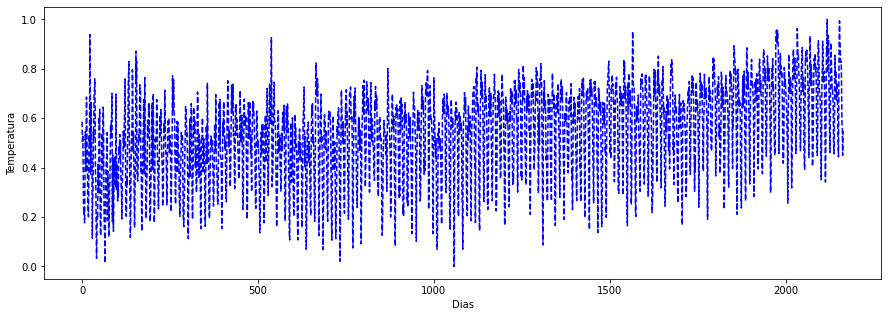

In [13]:
plt.figure(figsize=(15,5))
plt.plot(range(len(brazil_features)),brazil_features['AverageTemperature'], 'b--')
plt.xlabel("Dias")
plt.ylabel("Temperatura")
#plt.xlim(4000,4300)
plt.show()

In [14]:
time_steps = 365
test_size = 80

train_size = int(len(brazil_features)-(test_size))

#train_size = int(len(data_day_features)-(test_size))

train, test = brazil_features.iloc[0:train_size], brazil_features.iloc[(train_size-time_steps):len(brazil_features)]

#train, test = data_day_features.iloc[0:train_size], data_day_features.iloc[(train_size-time_steps):len(data_day_features)]

print(len(train), len(test))

2084 445


In [15]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps),0].to_numpy()
        v = np.append(v,X.iloc[i + time_steps,1])#d_semana
        v = np.append(v,X.iloc[i + time_steps,2])#d_mes
        v = np.append(v,X.iloc[i + time_steps,3])#d_ano
        Xs.append([v])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train['AverageTemperature'], time_steps)
X_test, y_test = create_dataset(test, test['AverageTemperature'], time_steps)



In [16]:
print(len(y_train),len(y_test))

1719 80


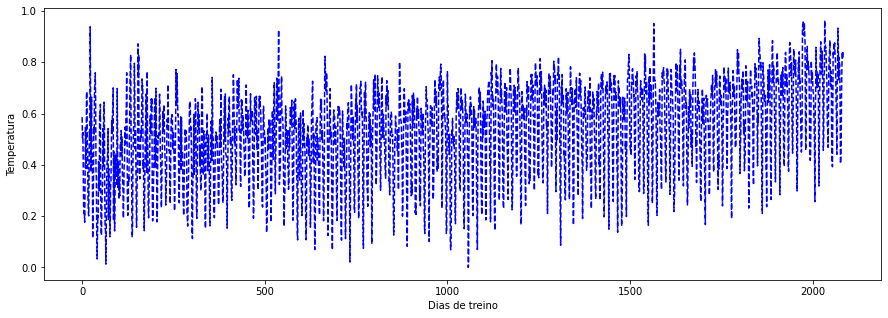

In [17]:
plt.figure(figsize=(15,5))
plt.plot(range(len(train)),train['AverageTemperature'], 'b--')
#plt.xlim(4000,4300)
plt.xlabel("Dias de treino")
plt.ylabel("Temperatura")
plt.show()

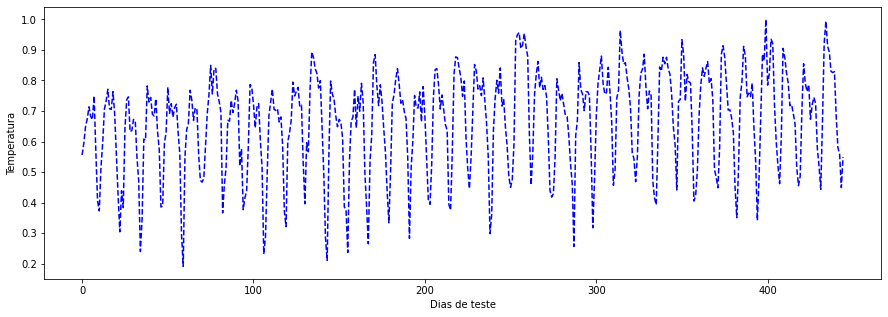

In [18]:
plt.figure(figsize=(15,5))
plt.plot(range(len(test)),test['AverageTemperature'], 'b--')
plt.xlabel("Dias de teste")
plt.ylabel("Temperatura")
#plt.xlim(4000,4300)
plt.show()

In [19]:
# nsamples, nx, ny = X_train.shape
# d2_xtrain_dataset = X_train.reshape((nsamples,nx*ny))
# d2_xtrain_dataset


In [20]:
# parameters = [{
# 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
# 'C': [1,2,3,300,500],
# 'max_iter': [1000,100000]}]

In [21]:
#clf = GridSearchCV(
#        SVR(), parameters, scoring='r2'
#    )
#x_fit = clf.fit(d2_xtrain_dataset, y_train)

In [22]:
# d2_xtrain_dataset

In [23]:
def getModel():
    model = tf.keras.Sequential()
    #leaky_relu = LeakyReLU(alpha=0.01)
    
    # MLP    
    # model.add(tf.keras.layers.Dense(300, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))
    # #model.add(tf.keras.layers.Dense(3000, activation="selu", input_shape=(X_train.shape[1], X_train.shape[2])))
    # #model.add(tf.keras.layers.Dense(1000, activation="selu")) 
    # #model.add(tf.keras.layers.Dense(900, activation="selu",input_shape=(X_train.shape[1], X_train.shape[2])))
    # #model.add(tf.keras.layers.Dense(300, activation="selu"))
    # model.add(tf.keras.layers.Dense(100, activation="relu"))
    # #model.add(tf.keras.layers.Dense(90, activation="relu"))
    # model.add(tf.keras.layers.Dense(30, activation="relu"))
    # model.add(tf.keras.layers.Dense(10, activation="relu"))
    
    # Vanilla LSTM
    #model.add(tf.keras.layers.LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
        
    # Stacked LSTM
    # model.add(tf.keras.layers.LSTM(3000, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(tf.keras.layers.LSTM(1000, activation='relu', return_sequences=True))
    # model.add(tf.keras.layers.LSTM(300, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(300, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(30, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(10, activation='relu'))
    
    # Bidirectional LSTM
#     model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(tf.keras.layers.Dense(units=1, activation='linear'))
    
    return model

In [24]:
model = getModel()

model.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001)
)

In [25]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')]

callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, restore_best_weights=True))

history = model.fit(
    X_train, y_train,
    epochs=1000, #1000
    batch_size=32, # 30
    validation_split=0.4,
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/1000
33/33 [==============================] - 6s 41ms/step - loss: 0.0995 - val_loss: 0.0127 - lr: 0.0010
Epoch 2/1000
33/33 [==============================] - 1s 18ms/step - loss: 0.0210 - val_loss: 0.0089 - lr: 0.0010
Epoch 3/1000
33/33 [==============================] - 1s 20ms/step - loss: 0.0140 - val_loss: 0.0069 - lr: 0.0010
Epoch 4/1000
33/33 [==============================] - 1s 19ms/step - loss: 0.0128 - val_loss: 0.0065 - lr: 0.0010
Epoch 5/1000
33/33 [==============================] - 1s 18ms/step - loss: 0.0113 - val_loss: 0.0070 - lr: 0.0010
Epoch 6/1000
33/33 [==============================] - 1s 18ms/step - loss: 0.0101 - val_loss: 0.0097 - lr: 0.0010
Epoch 7/1000
33/33 [==============================] - 1s 19ms/step - loss: 0.0092 - val_loss: 0.0141 - lr: 0.0010
Epoch 8/1000
33/33 [==============================] - 1s 18ms/step - loss: 0.0086 - val_loss: 0.0160 - lr: 0.0010
Epoch 9/1000
33/33 [==============================] - 1s 18ms/step - loss: 0.0082 - val_

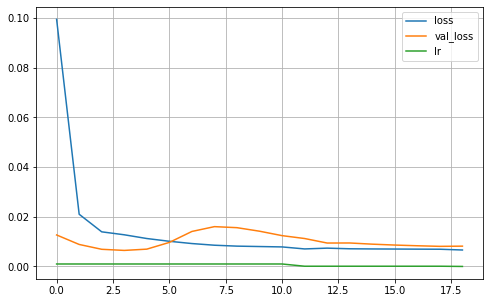

In [26]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Avaliando o modelo

In [27]:
# PREVENDO test_size DIAS

preds = []

base_teste = np.copy(X_test)

for i in range(len(base_teste)):
    
    y_pred = model.predict(np.array([base_teste[i]]))[0][0]

    preds.append(y_pred)

    for k in range(len(preds)):
        
        if k < time_steps:
            if(i<len(base_teste)-1):
                base_teste[i+1][0][(time_steps-1)-k] = preds[(len(preds)-1)-k]

# preds

In [28]:
base_teste[0].shape

(1, 368)

In [29]:
# APLICANDO O INVERSE SCALING NOS DADOS

dados_pred = {'AverageTemperature': preds,'d_semana': [0] * test_size,'d_mes': [0] * test_size,'d_ano': [0] * test_size} # 

brazil_features = brazil_features.append(pd.DataFrame(data=dados_pred))

if(transformar_features):
    brazil_features[feature_names] = scaler.inverse_transform(brazil_features[feature_names])
# feature_names = ['PU','Quantidade', 'Valor','d_semana','d_mes','d_ano']
df_dados_real_predito = brazil_features.tail(test_size*2)


dados_real = df_dados_real_predito [0:test_size]['AverageTemperature'].to_numpy()

dados_predito = df_dados_real_predito [test_size:test_size*2]['AverageTemperature'].to_numpy()


# dados_predito

In [30]:
df_real_predito = pd.DataFrame({'real':dados_real,'predito':dados_predito})

df_real_predito

,real,predito
0,26.409,26.007647
1,26.026,25.956326
2,26.112,25.833567
3,25.750,25.493571
4,24.519,24.954528
...,...,...
75,25.464,25.592779
76,24.906,25.123786
77,24.788,24.791954
78,24.202,24.855626


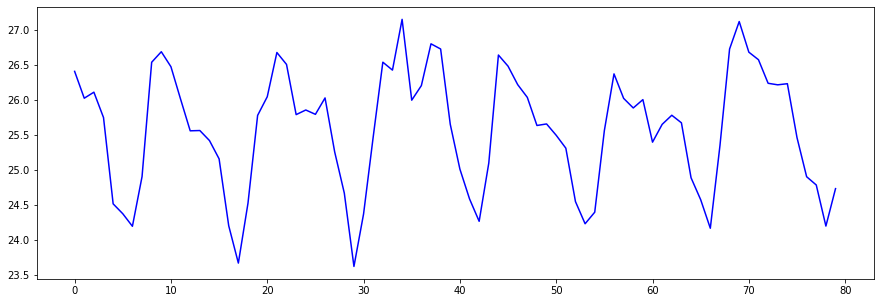

In [31]:
plt.figure(figsize=(15,5))

plt.plot(range(len(df_real_predito['real'])),df_real_predito['real'], 'b')

plt.show()

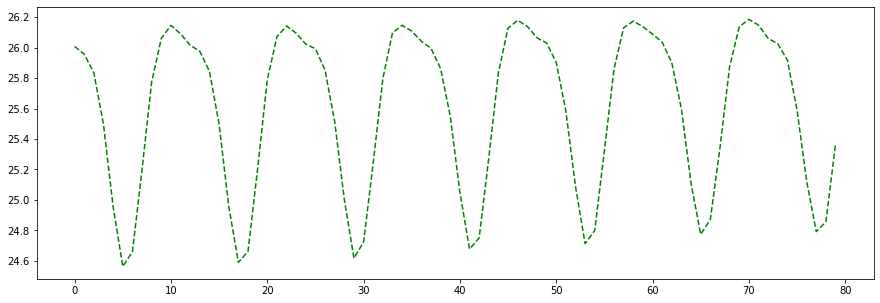

In [32]:
plt.figure(figsize=(15,5))
plt.plot(range(len(df_real_predito['predito'])),df_real_predito['predito'], 'g--')
plt.show()

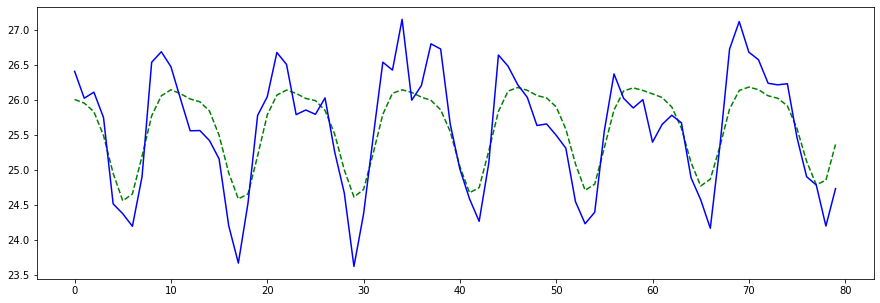

In [33]:
plt.figure(figsize=(15,5))
# plt.plot(range(len(y_train)),y_train, 'g--')
plt.plot(range(len(df_real_predito['predito'])),df_real_predito['predito'], 'g--')
plt.plot(range(len(df_real_predito['real'])),df_real_predito['real'], 'b')
# plt.xlim(0,200)
# plt.ylim(40,200)
plt.show()

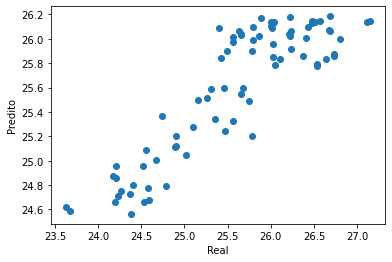

rmse= 0.4568330570451228
mae= 0.3783792477488518
r2= 0.7132318426016391


In [34]:
plt.scatter(df_real_predito['real'],df_real_predito['predito'])

plt.xlabel('Real')
plt.ylabel('Predito')

plt.show()
print('rmse=',sqrt(mean_squared_error(df_real_predito['real'].array,df_real_predito['predito'].array)))
print('mae=',mean_absolute_error(df_real_predito['real'].array,df_real_predito['predito'].array))
print('r2=',r2_score(df_real_predito['real'].array,df_real_predito['predito'].array))